In [1]:
import os
import sys
sys.path.append("../../../")

from rnns_architectures.intrinsec import *
from rnns_architectures.utils import *

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import random, os, json

import matplotlib.pyplot as plt
import seaborn as sns

import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


import warnings
warnings.filterwarnings("ignore")

2025-01-12 15:54:33.477497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 15:54:33.990591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
n_time_steps = 8
norm = "robustNorm"

# Explainability. Heatmaps 


In [3]:
features =  ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20',
       'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41',
       'pm42', 'pm43', 'pm44', 'pm87']

new_order = ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20',
       'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41',
       'pm42', 'pm43', 'pm44', 'pm87']

feature_to_index = {feature: idx for idx, feature in enumerate(features)}
new_indices = [feature_to_index[feature] for feature in new_order]

In [4]:
directory = './Results_GRU_Had'
def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

hadamard_scores_data = {}
hadamard_scores_data_1 = load_from_pickle(os.path.join('./Results_GRU_Had/split_1', "hadamard_scores_split_1.pkl"))
hadamard_scores_data_2 = load_from_pickle(os.path.join('./Results_GRU_Had/split_2', "hadamard_scores_split_2.pkl"))
hadamard_scores_data_3 = load_from_pickle(os.path.join('./Results_GRU_Had/split_3', "hadamard_scores_split_3.pkl"))

hadamard_scores_data['1'] = hadamard_scores_data_1
hadamard_scores_data['2'] = hadamard_scores_data_2
hadamard_scores_data['3'] = hadamard_scores_data_3

## Visualization

## PATIENTS WITH CIRCULATORY FAILURE

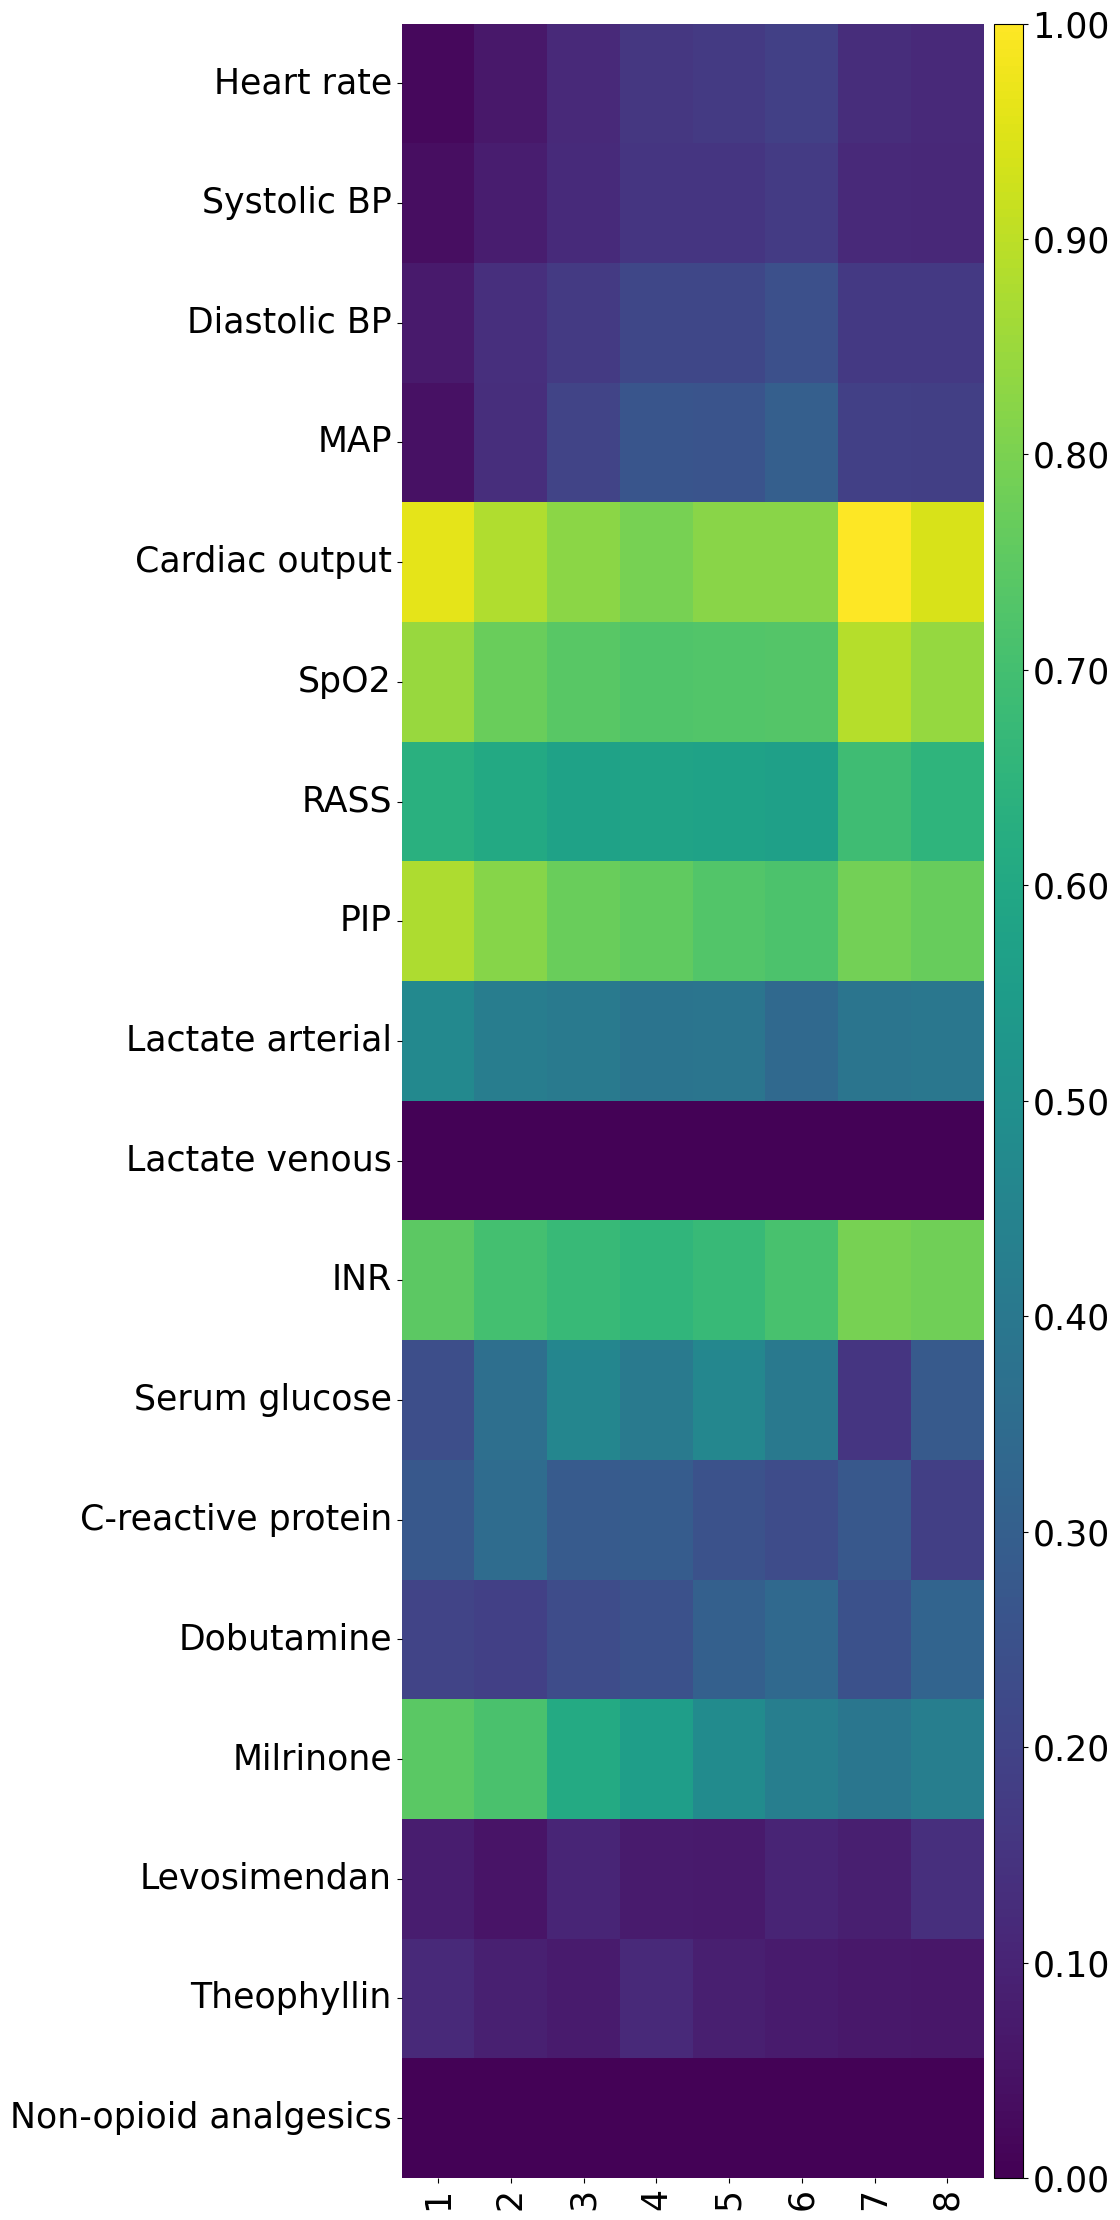

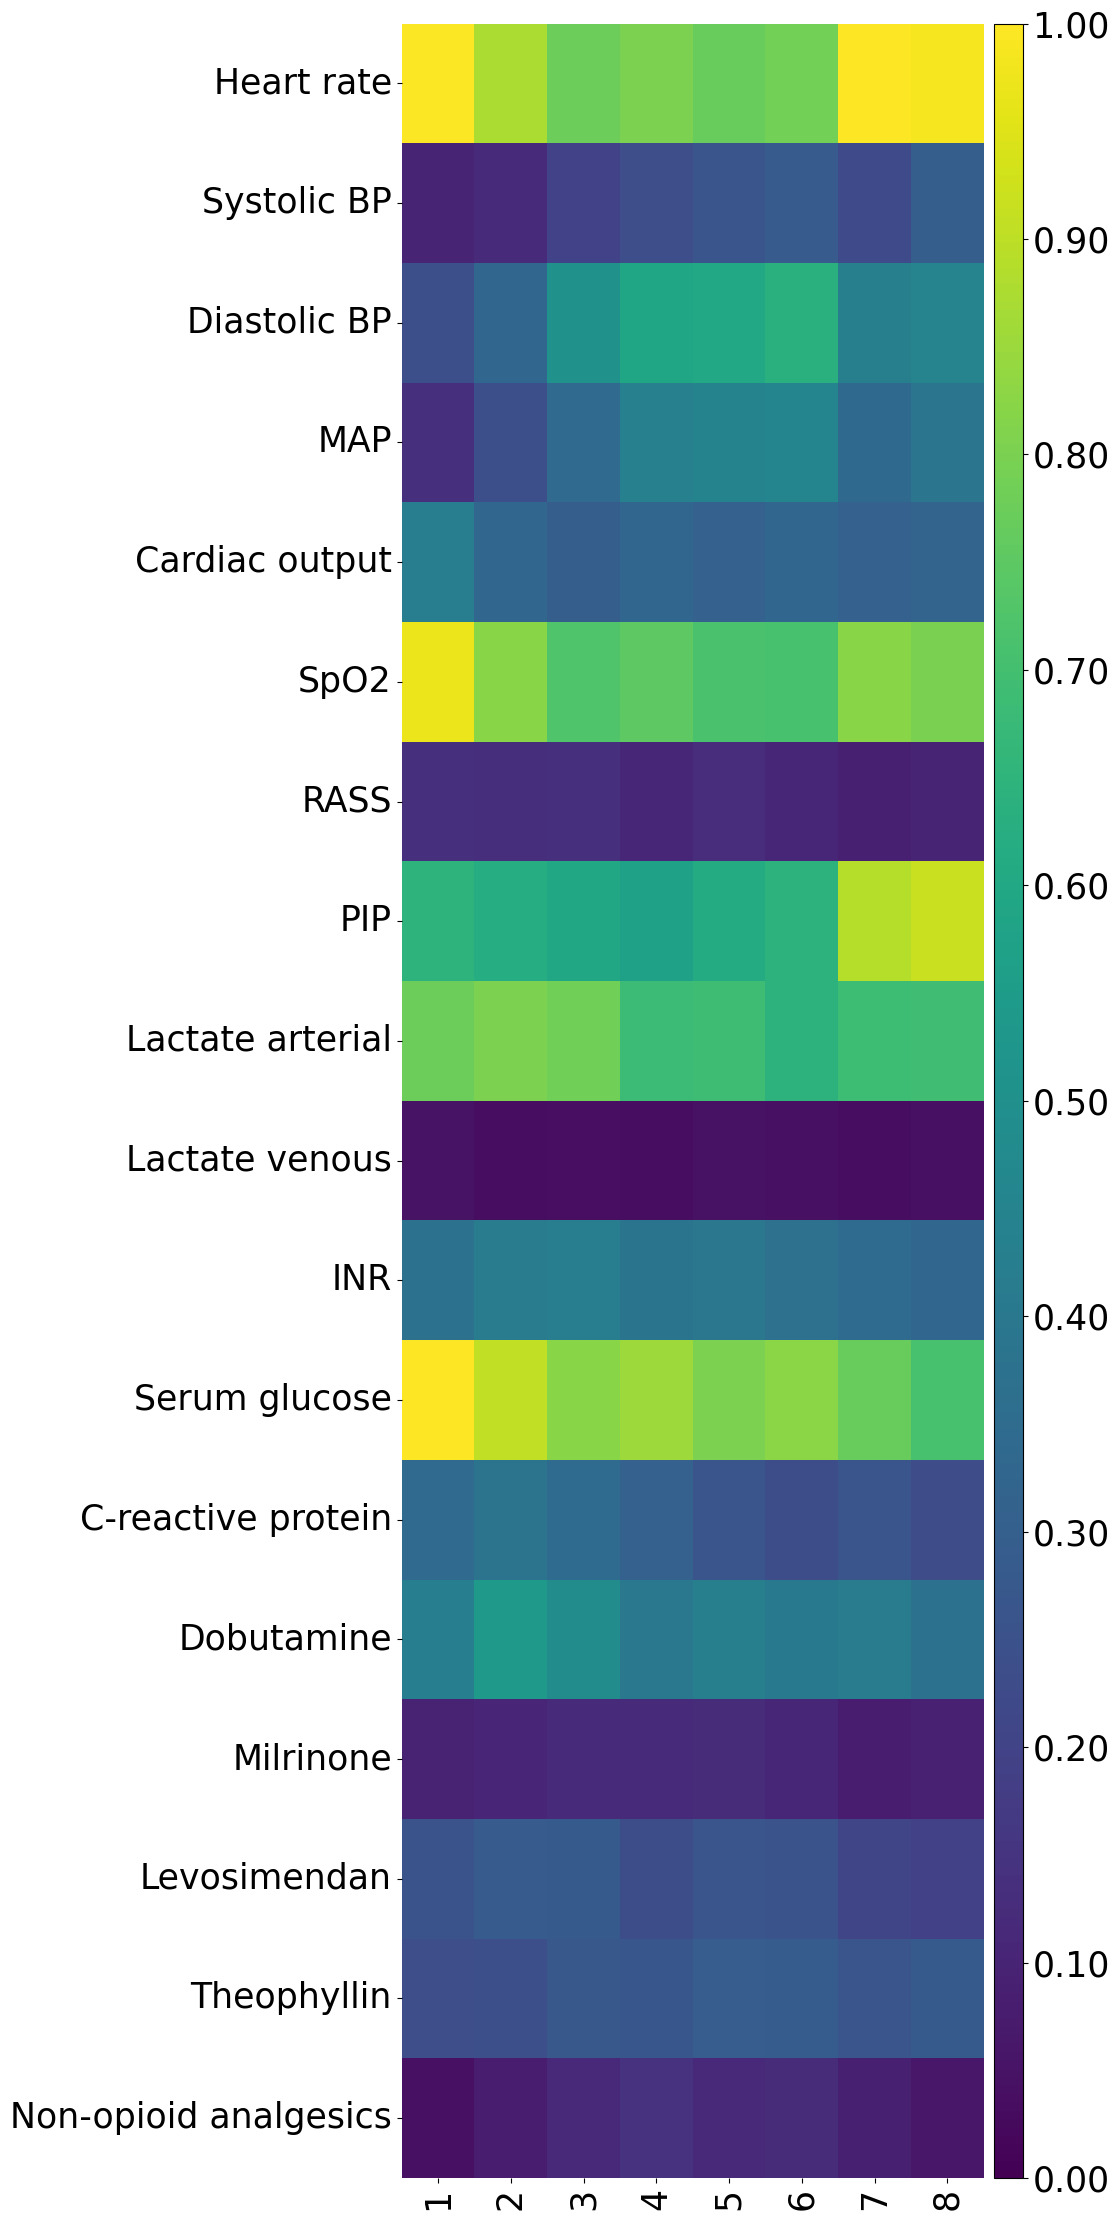

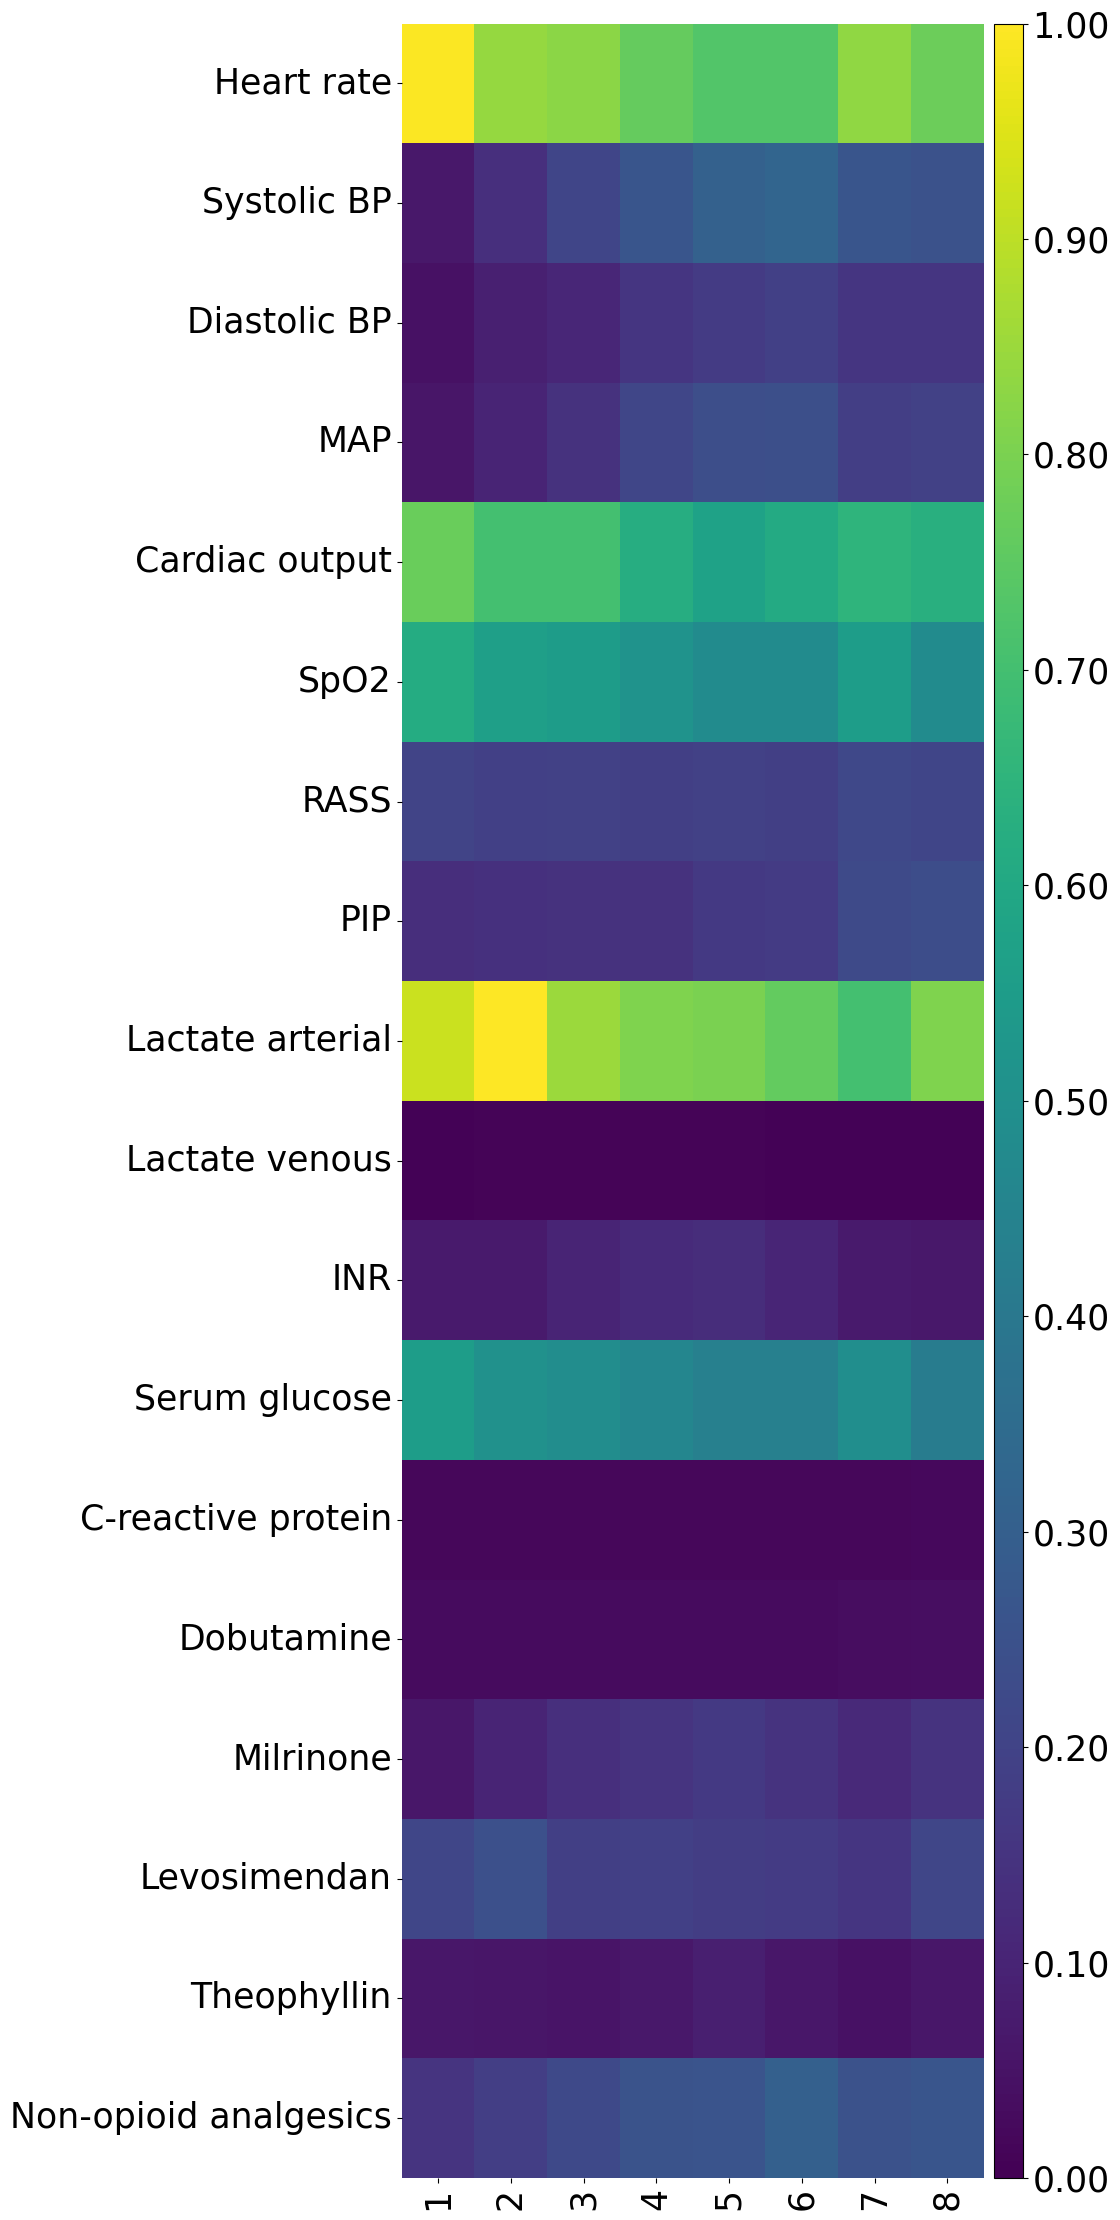

In [5]:
dfsplits_amr = []

final_order = ["Heart rate",
    "Systolic BP",
    "Diastolic BP",
    "MAP",
    "Cardiac output",
    "SpO2",
    "RASS",
    "PIP",
    "Lactate arterial",
    "Lactate venous",
    "INR",
    "Serum glucose",
    "C-reactive protein",
    "Dobutamine",
    "Milrinone",
    "Levosimendan",
    "Theophyllin",
    "Non-opioid analgesics"]

for i in [1, 2, 3]:
    X_test = np.load(f"../../../DATA/CIRCULATORY/s{i}/X_test_tensor_{norm}.npy")    
    y_test_or = pd.read_csv(f"../../../DATA/CIRCULATORY/s{i}/y_test_tensor_{norm}.csv")

    y_test = y_test_or[y_test_or.individualMRGerm != 666]
    y_test = y_test.groupby(by="Admissiondboid").sum().reset_index()
    amr = y_test[y_test.individualMRGerm != 0].index

    y_test_or = y_test_or.loc[:, 'individualMRGerm'].values.reshape(y_test_or.shape[0] // n_time_steps, n_time_steps)
    weights = hadamard_scores_data[str(i)][0]
    
    #### AMR PATIENTS
    # Step 1: Find the indexes where y_test_or is equal to 1
    idx_amr = np.where(y_test_or == 1)
    # Step 2: Create a boolean mask with the same shape as y_test_or
    mask = np.full(y_test_or.shape, False)
    mask[idx_amr] = True
    # Step 3: Create an array of NaNs with the same shape as weights
    nan_weights = np.full(weights.shape, np.nan)
    # Step 4: Copy the weights elements where mask is True
    nan_weights[mask] = weights[mask]

    dfsplits_amr.append(nan_weights)
    average_weights_amr = np.nanmean(nan_weights, axis=0) / np.nanmean(nan_weights, axis=0).max()
    reordered_average_weights_amr = average_weights_amr.T[new_indices, :]

    plt.figure(figsize=(11,22))
    ax = plt.gca()
    
    # Set the vmin and vmax parameters to control the color scaling explicitly
    vmin = 0  # Start color range from 0
    vmax = 1  # End color range at 1

    heatmap = sns.heatmap(
        reordered_average_weights_amr,
        cmap='viridis',
        xticklabels=np.arange(reordered_average_weights_amr.shape[1]) + 1,  # Set x-axis tick labels
        yticklabels=final_order,
        ax=ax,
        cbar=False,  # Disable the default color bar
        vmin=vmin,
        vmax=vmax
    )

    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=25)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=25, rotation=90)

    # Create colorbar with adjusted range
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cax)
    cbar.ax.tick_params(labelsize=22)

    # Set custom ticks on the colorbar with the first value as 0
    num_ticks = 11  # Set the number of ticks you want
    tick_locs = np.linspace(vmin, vmax, num_ticks)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in tick_locs])
    cbar.ax.tick_params(labelsize=25)

    plt.tight_layout(pad=0)
    plt.savefig('../Figures/INTRINSIC/GRU_Had_mdr_s'+str(i)+'.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

## PATIENTS WITHOUT CIRCULATORY FAILURE

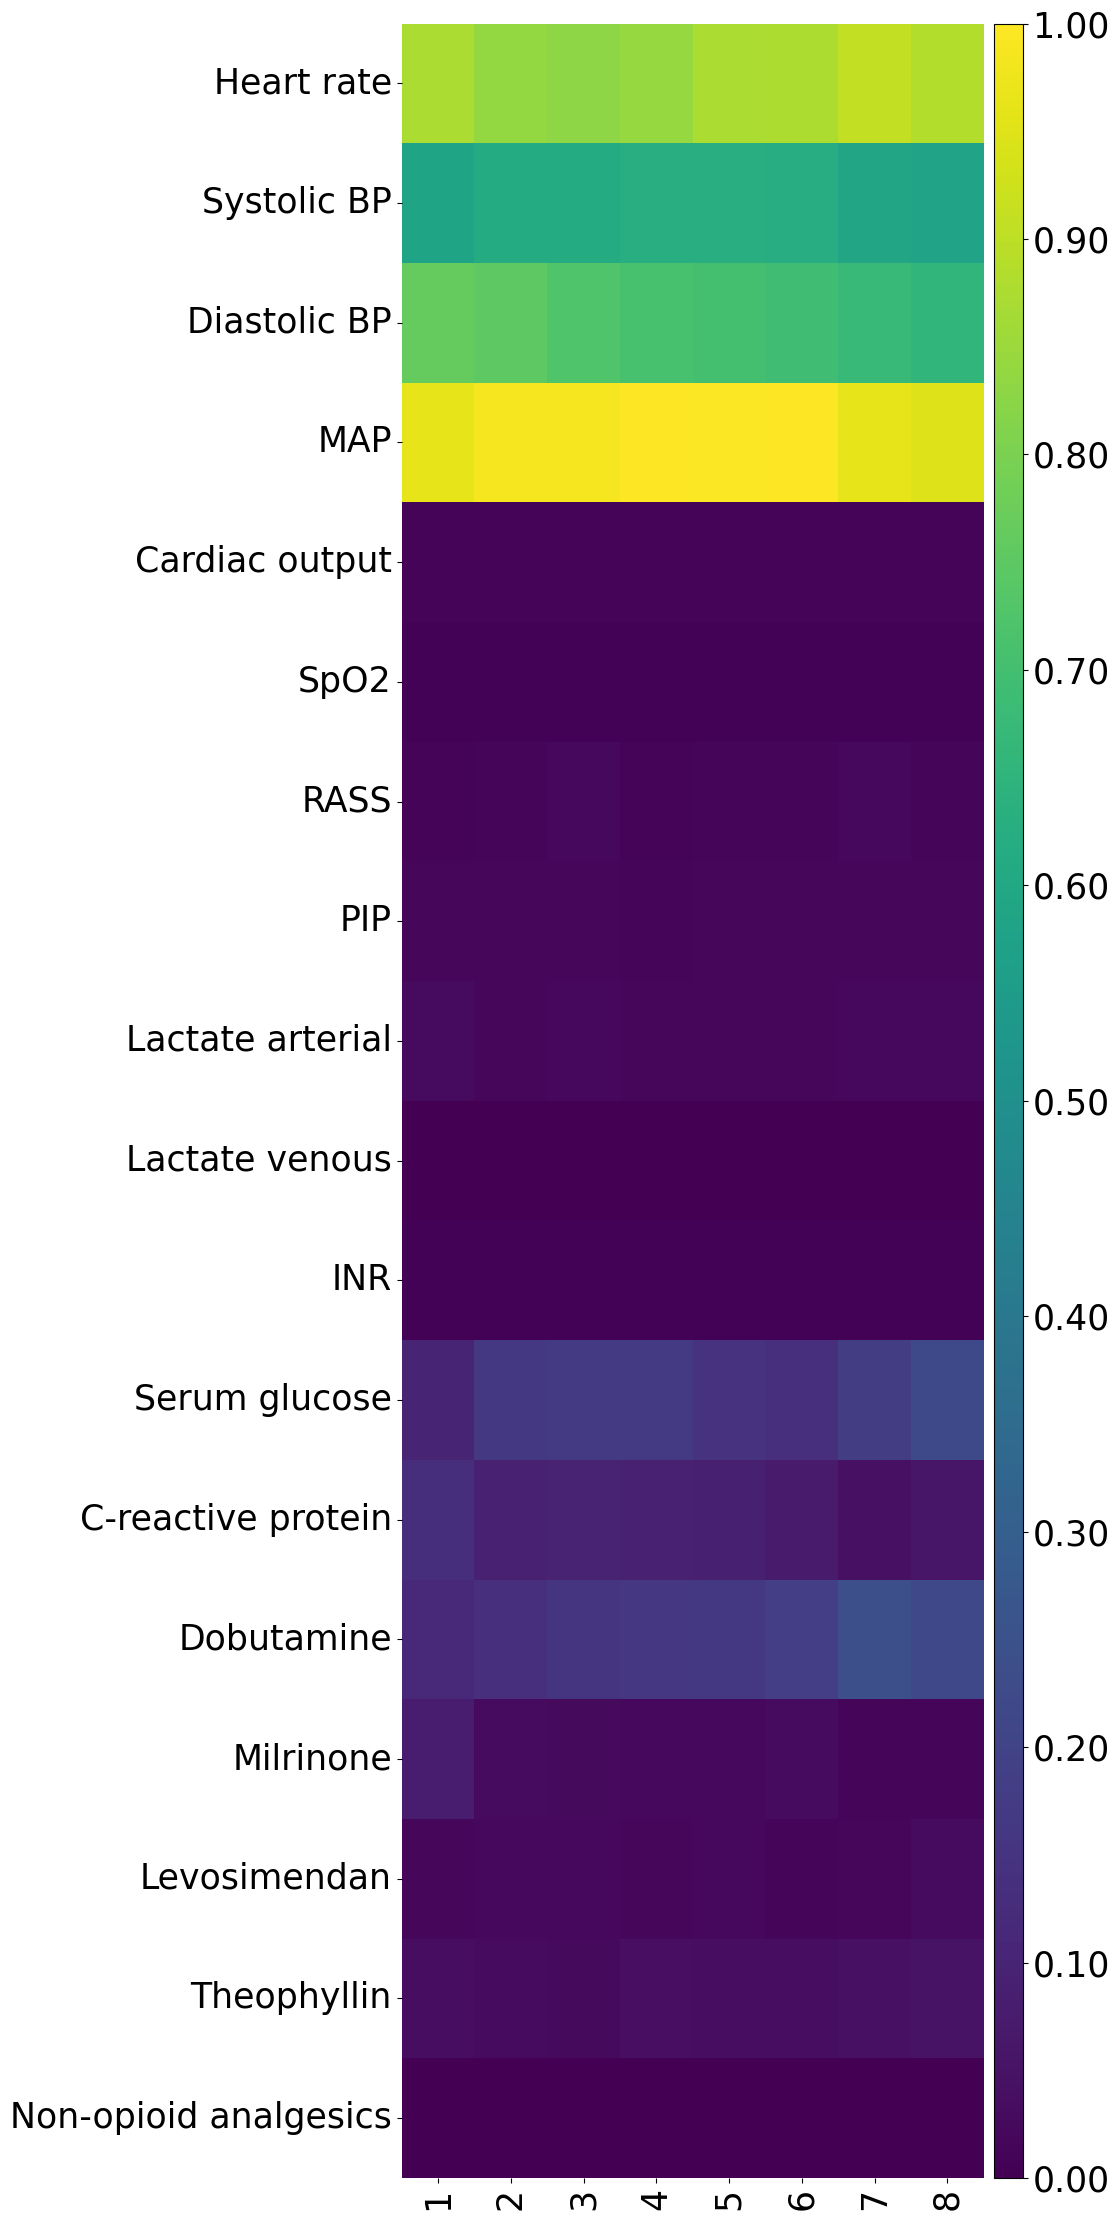

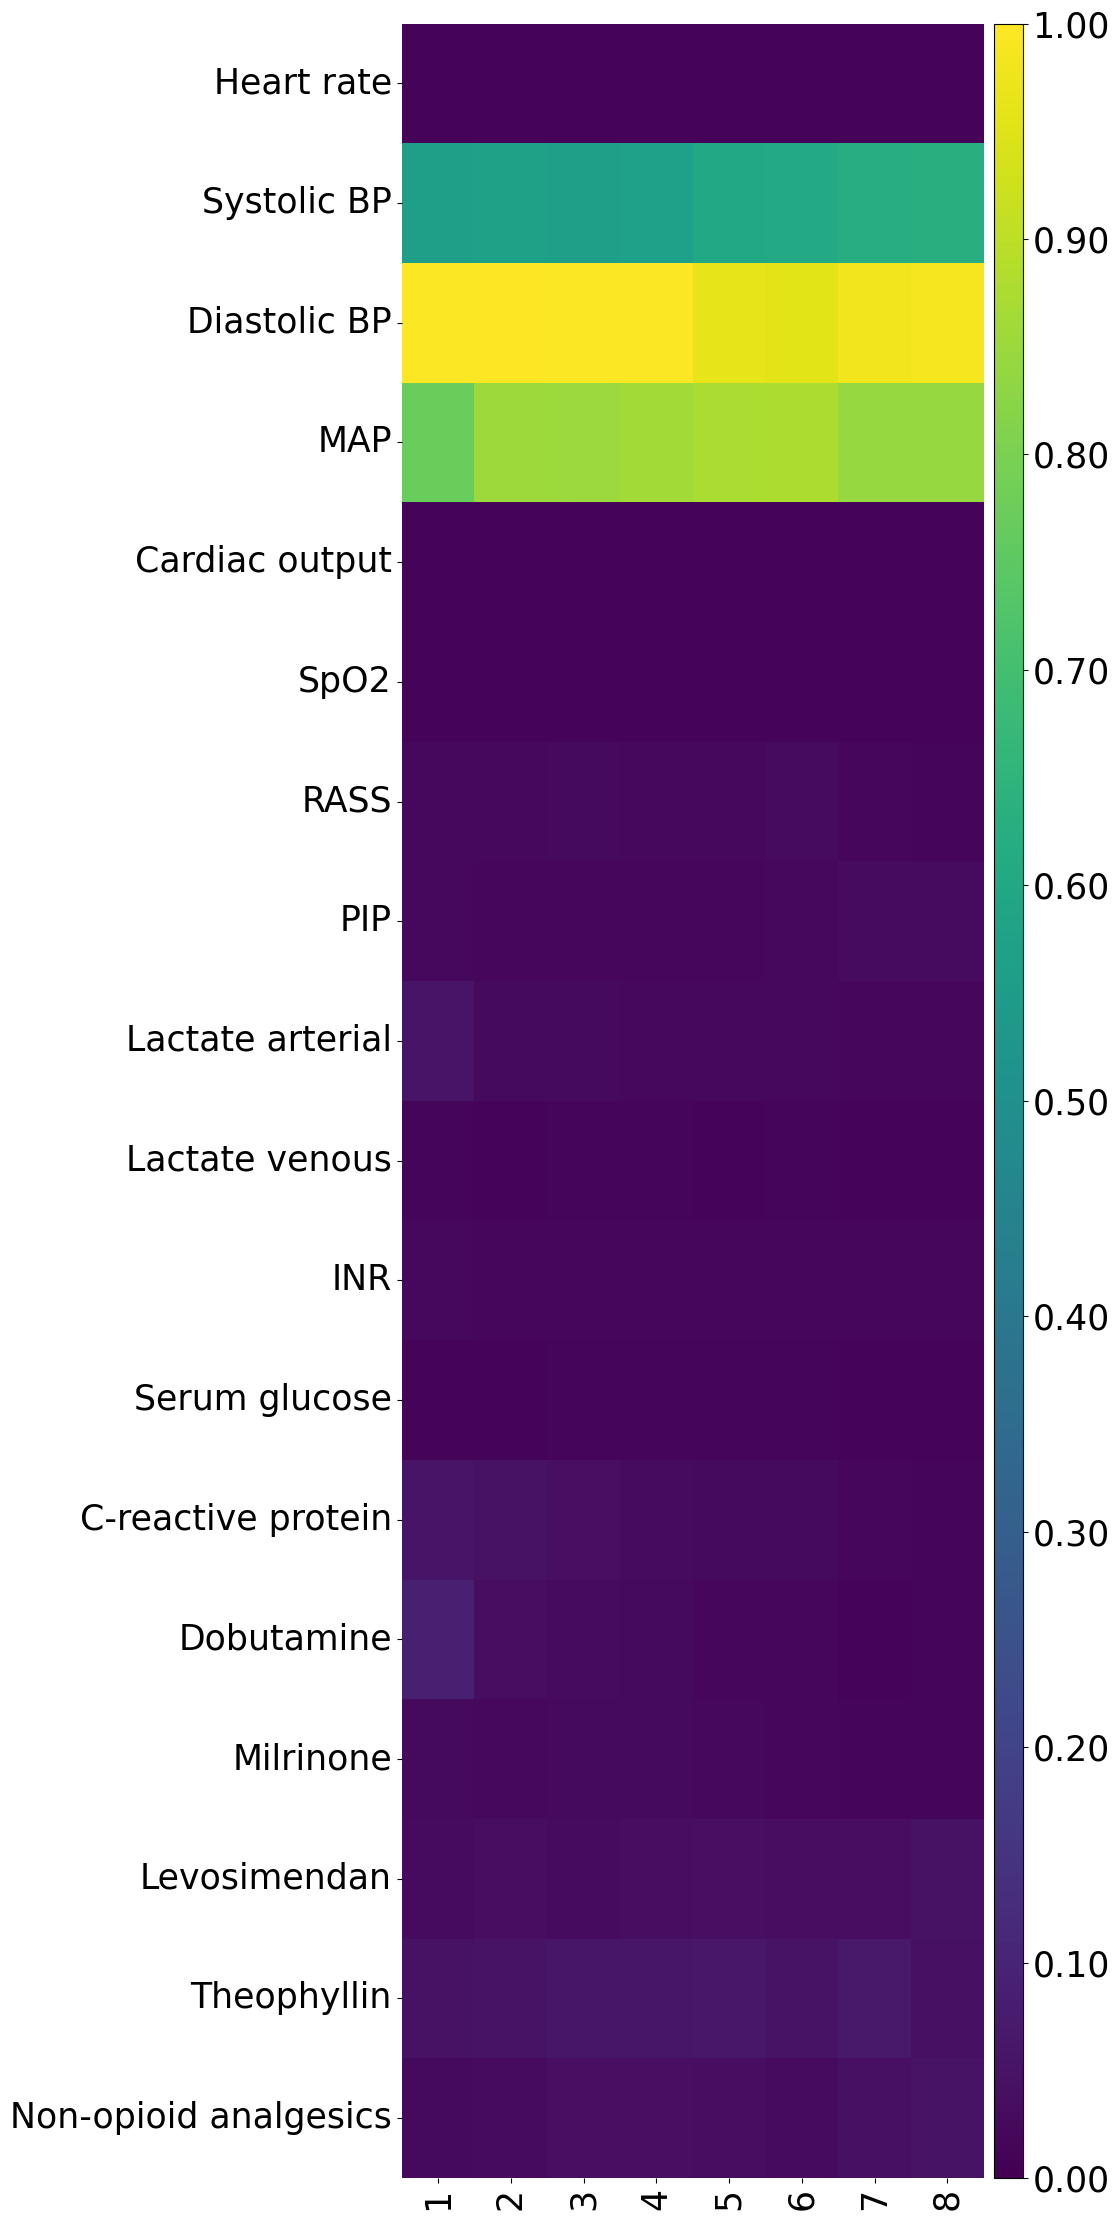

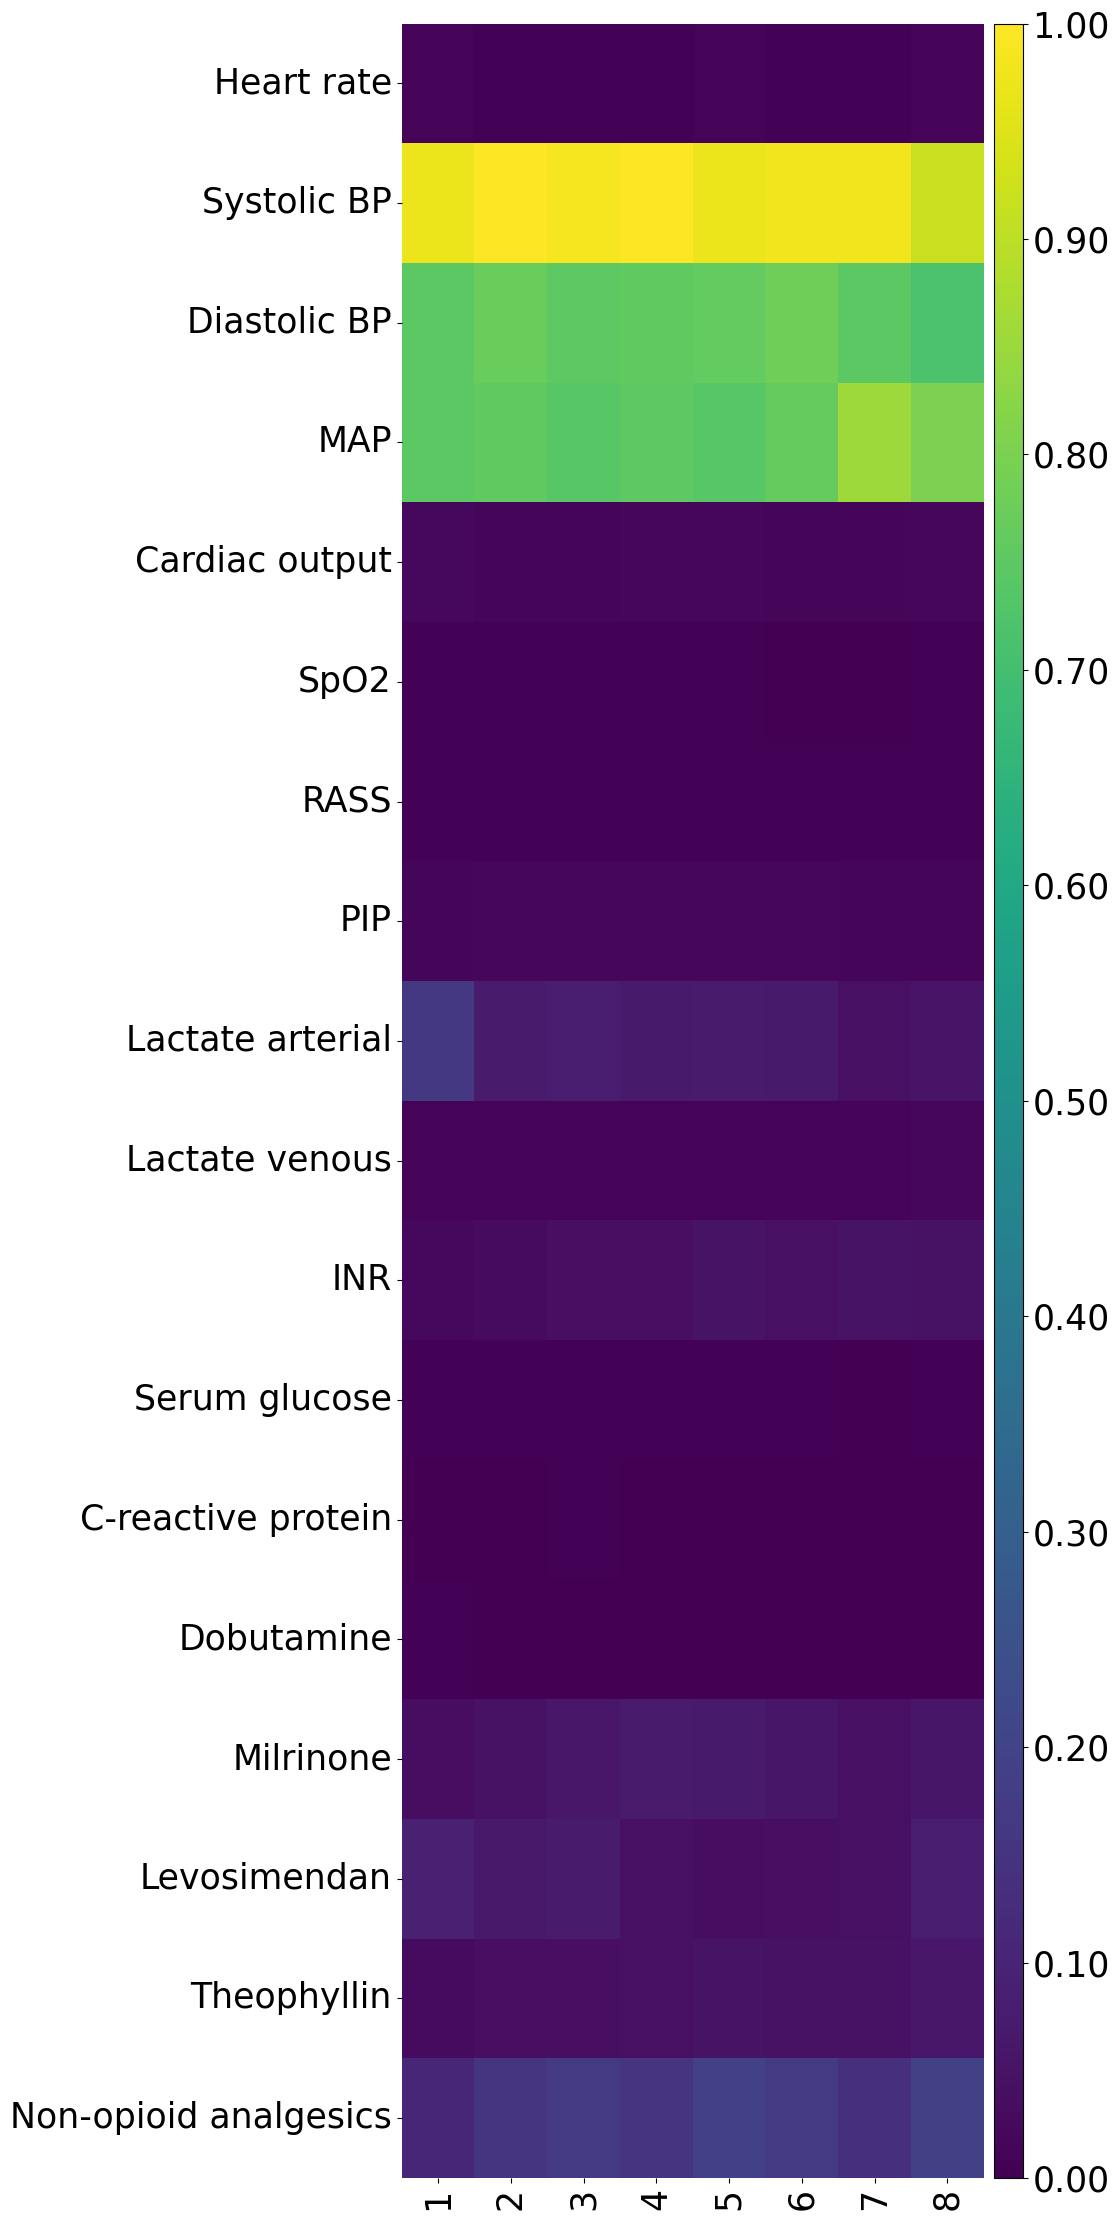

In [6]:
dfsplits_noamr = []

for i in [1, 2, 3]:
    X_test = np.load(f"../../../DATA/CIRCULATORY/s{i}/X_test_tensor_{norm}.npy")    
    y_test_or = pd.read_csv(f"../../../DATA/CIRCULATORY/s{i}/y_test_tensor_{norm}.csv")
    
    y_test = y_test_or[y_test_or.individualMRGerm != 666]
    y_test = y_test.groupby(by="Admissiondboid").sum().reset_index()
    amr = y_test[y_test.individualMRGerm != 0].index
    noamr = y_test[y_test.individualMRGerm == 0].index

    y_test_or = y_test_or.loc[:, 'individualMRGerm'].values.reshape(y_test_or.shape[0] // n_time_steps, n_time_steps)
    weights = hadamard_scores_data[str(i)][0]
    
    #### NON AMR PATIENTS
    # Step 1: Find the indexes where y_test_or is equal to 0
    idx_noamr = np.where(y_test_or == 0)
    
    # Step 2: Create a boolean mask with the same shape as y_test_or
    mask = np.full(y_test_or.shape, False)
    mask[idx_noamr] = True
    
    # Step 3: Create an array of NaNs with the same shape as weights
    nan_weights = np.full(weights.shape, np.nan)
    
    # Step 4: Copy the weights elements where mask is True
    nan_weights[mask] = weights[mask]
    dfsplits_noamr.append(nan_weights)

    average_weights_noamr = np.nanmean(nan_weights, axis=0) / np.nanmean(nan_weights, axis=0).max()
    
    # Reorder the average weights (assuming new_indices is defined)
    reordered_average_weights_noamr = average_weights_noamr.T[new_indices, :]
    
    # Create the heatmap
    plt.figure(figsize=(11,22))
    ax = plt.gca()
    
    # Set the vmin and vmax parameters to control the color scaling explicitly
    vmin = 0  # Start color range from 0
    vmax = 1  # End color range at 1

    heatmap = sns.heatmap(
        reordered_average_weights_noamr,
        cmap='viridis',
        xticklabels=np.arange(reordered_average_weights_noamr.shape[1]) + 1,  # Set x-axis tick labels
        yticklabels=final_order,
        ax=ax,
        cbar=False,  # Disable the default color bar
        vmin=vmin,
        vmax=vmax
    )

    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=25)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=25, rotation=90)

    # Create colorbar with adjusted range
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cax)
    cbar.ax.tick_params(labelsize=22)

    # Set custom ticks on the colorbar with the first value as 0
    num_ticks = 11  # Set the number of ticks you want
    tick_locs = np.linspace(vmin, vmax, num_ticks)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in tick_locs])
    cbar.ax.tick_params(labelsize=25)

    # Save and display the plot
    plt.tight_layout(pad=0)
    plt.savefig(f'../Figures/INTRINSIC/GRU_Had_nomdr_s{i}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

## Population analysis

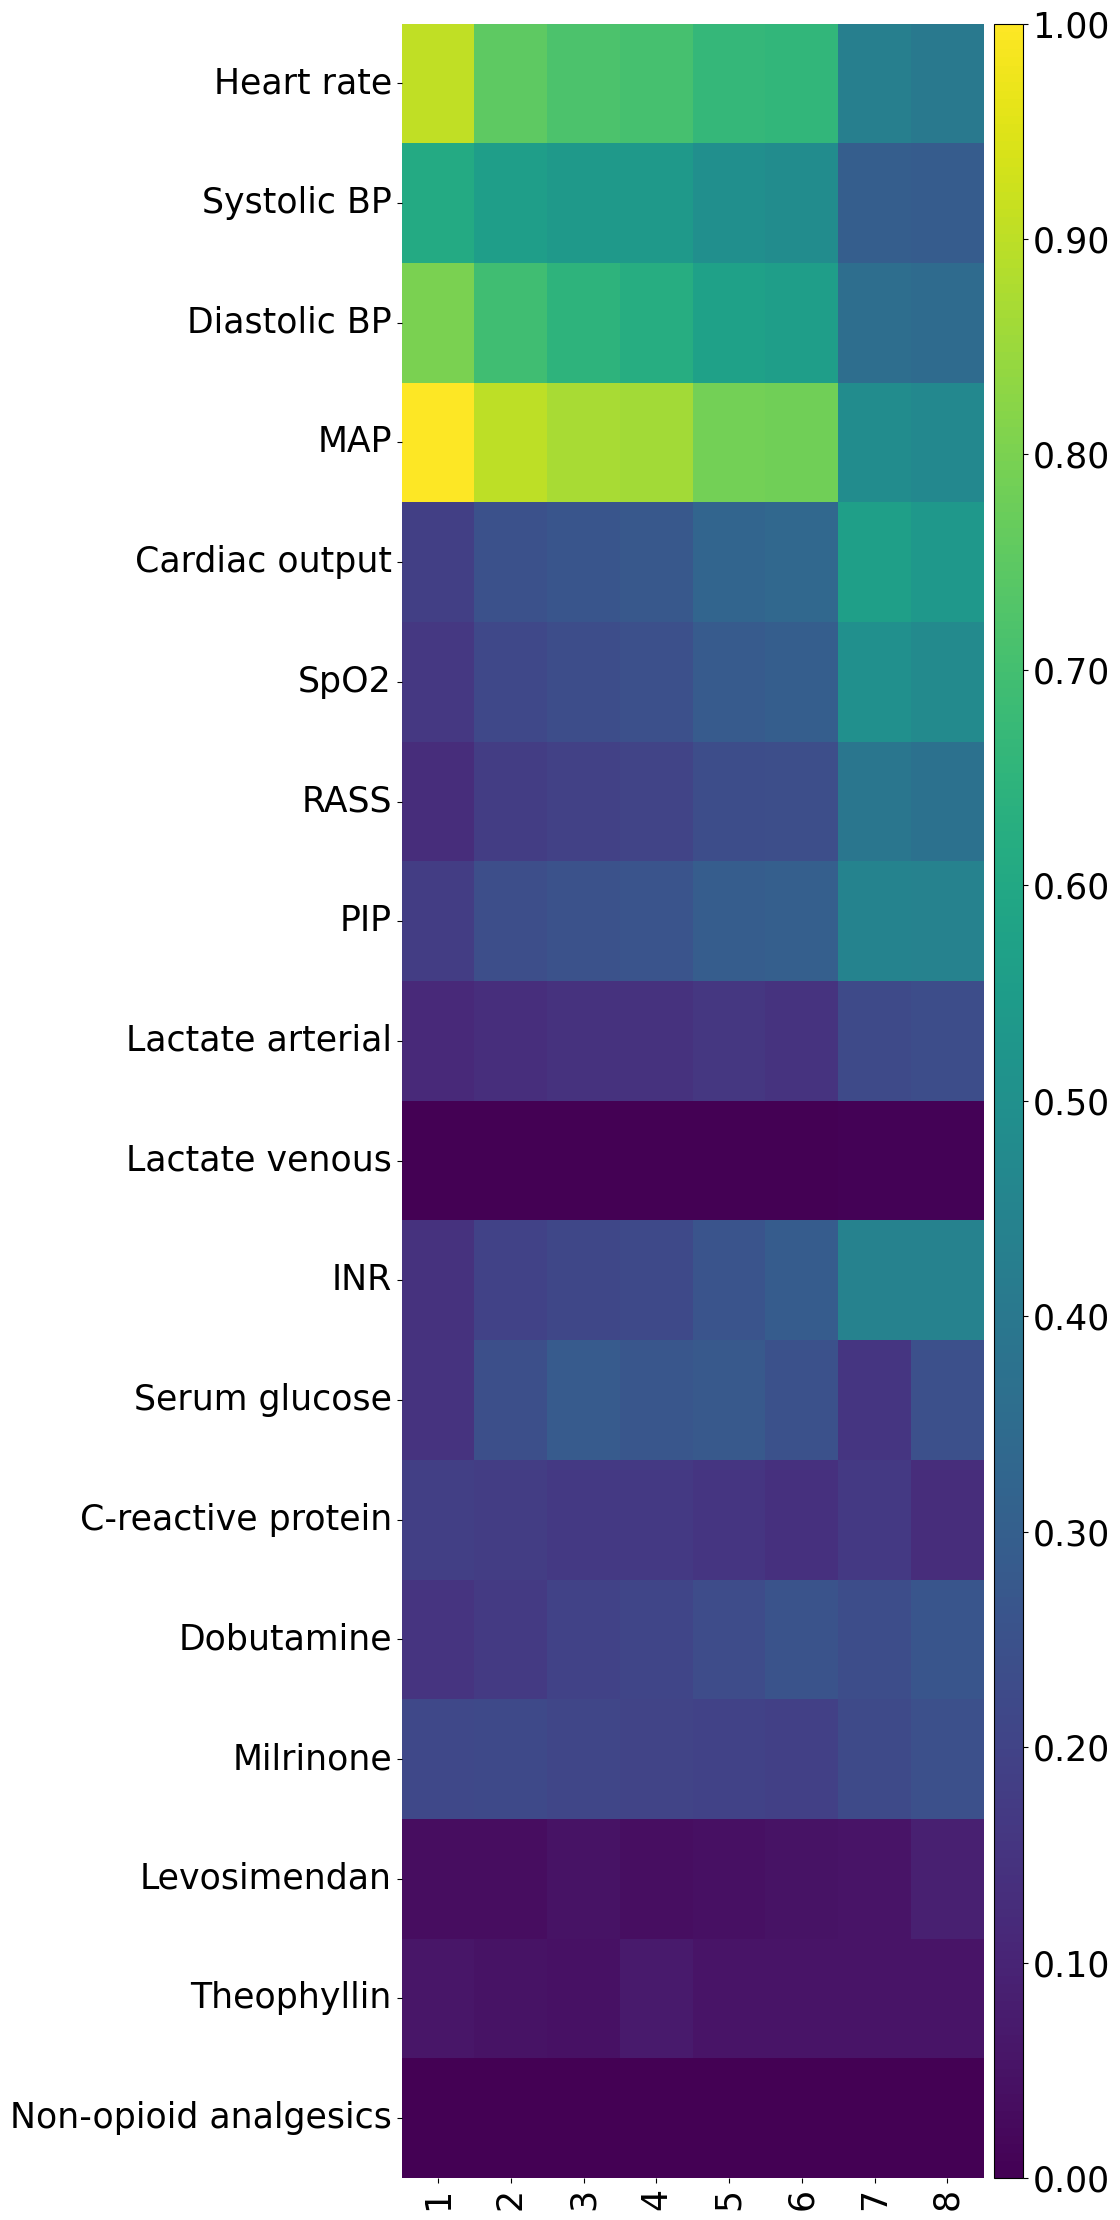

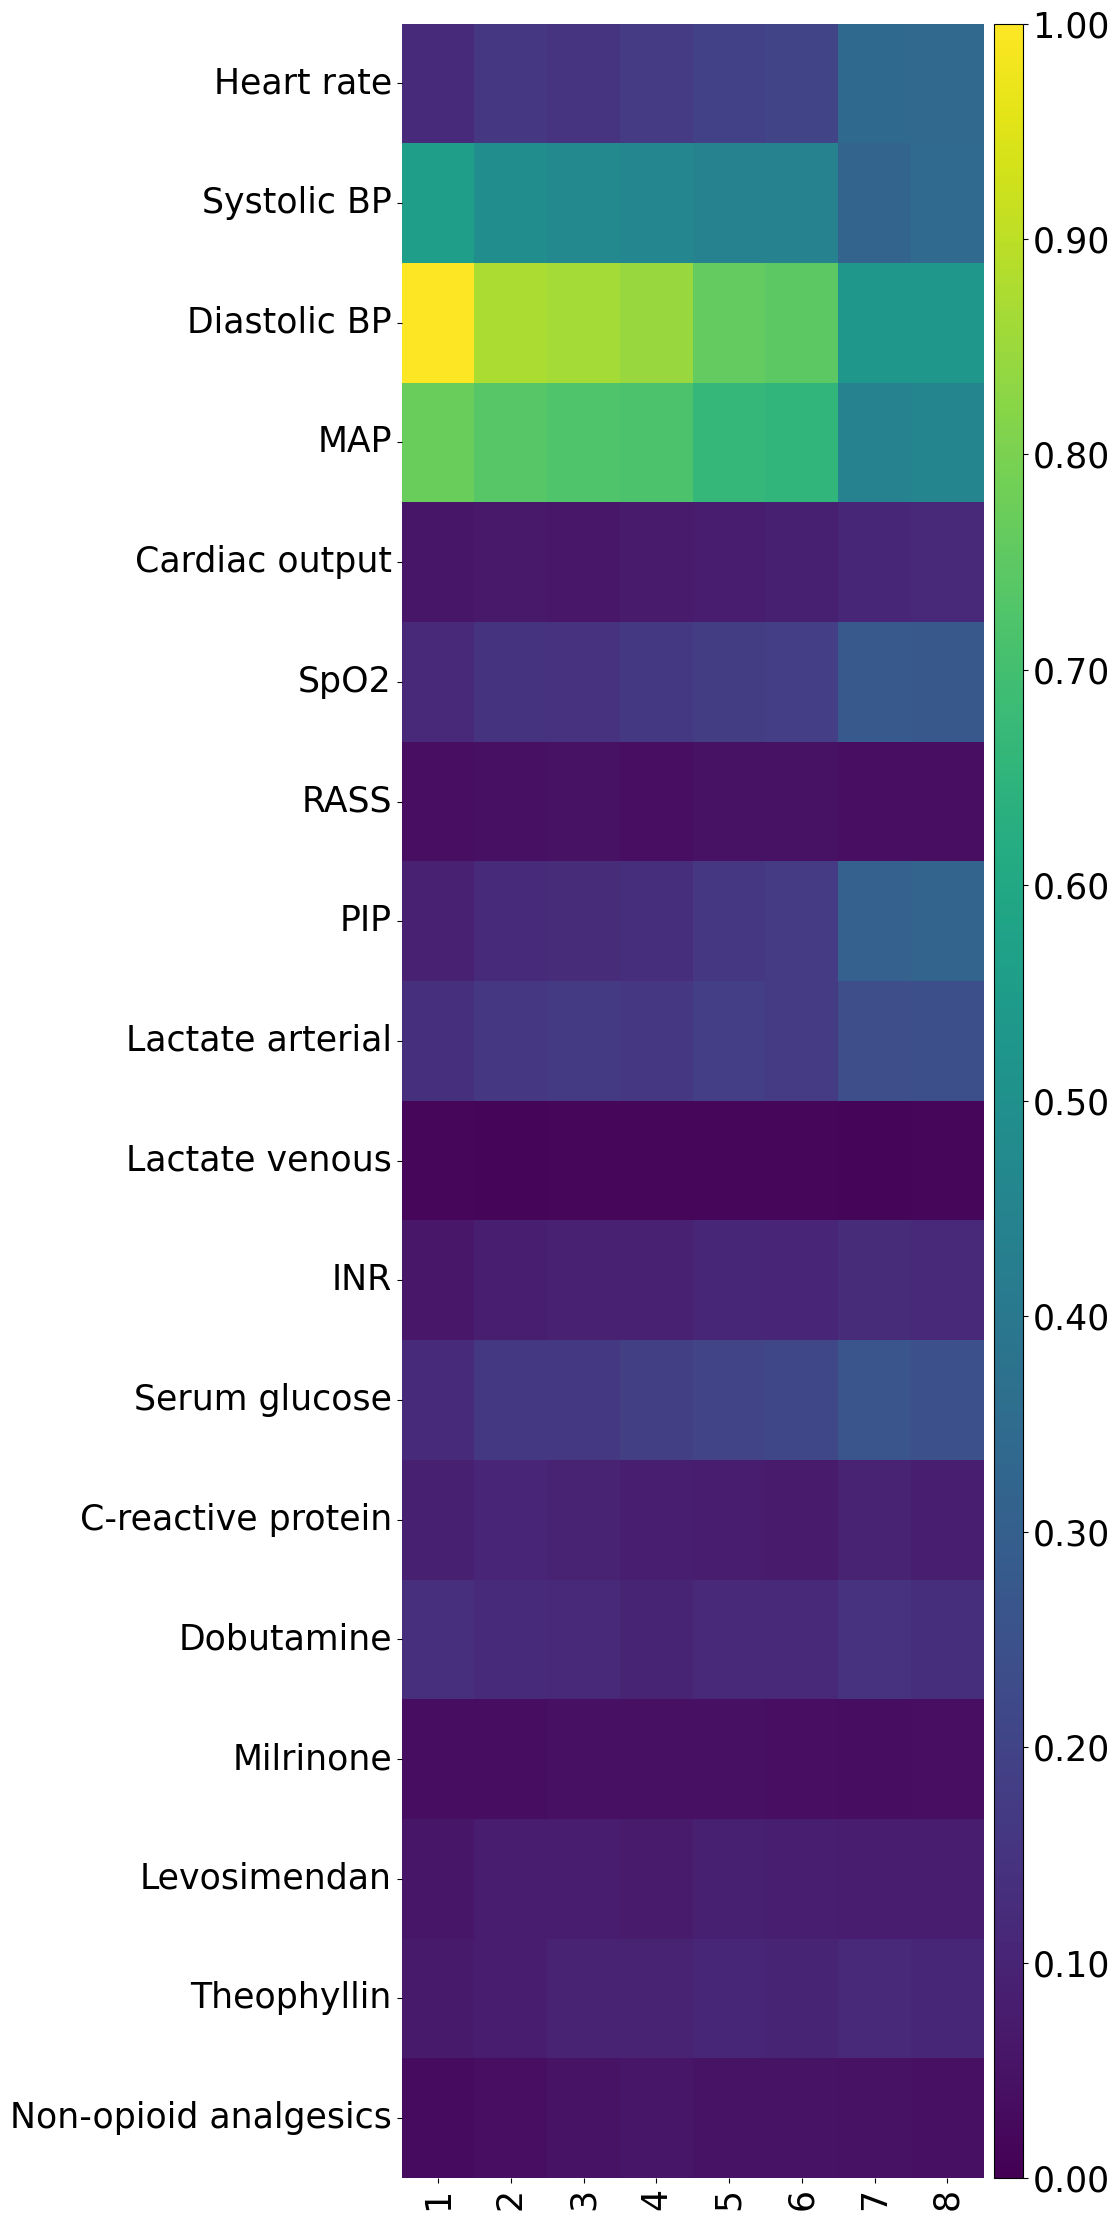

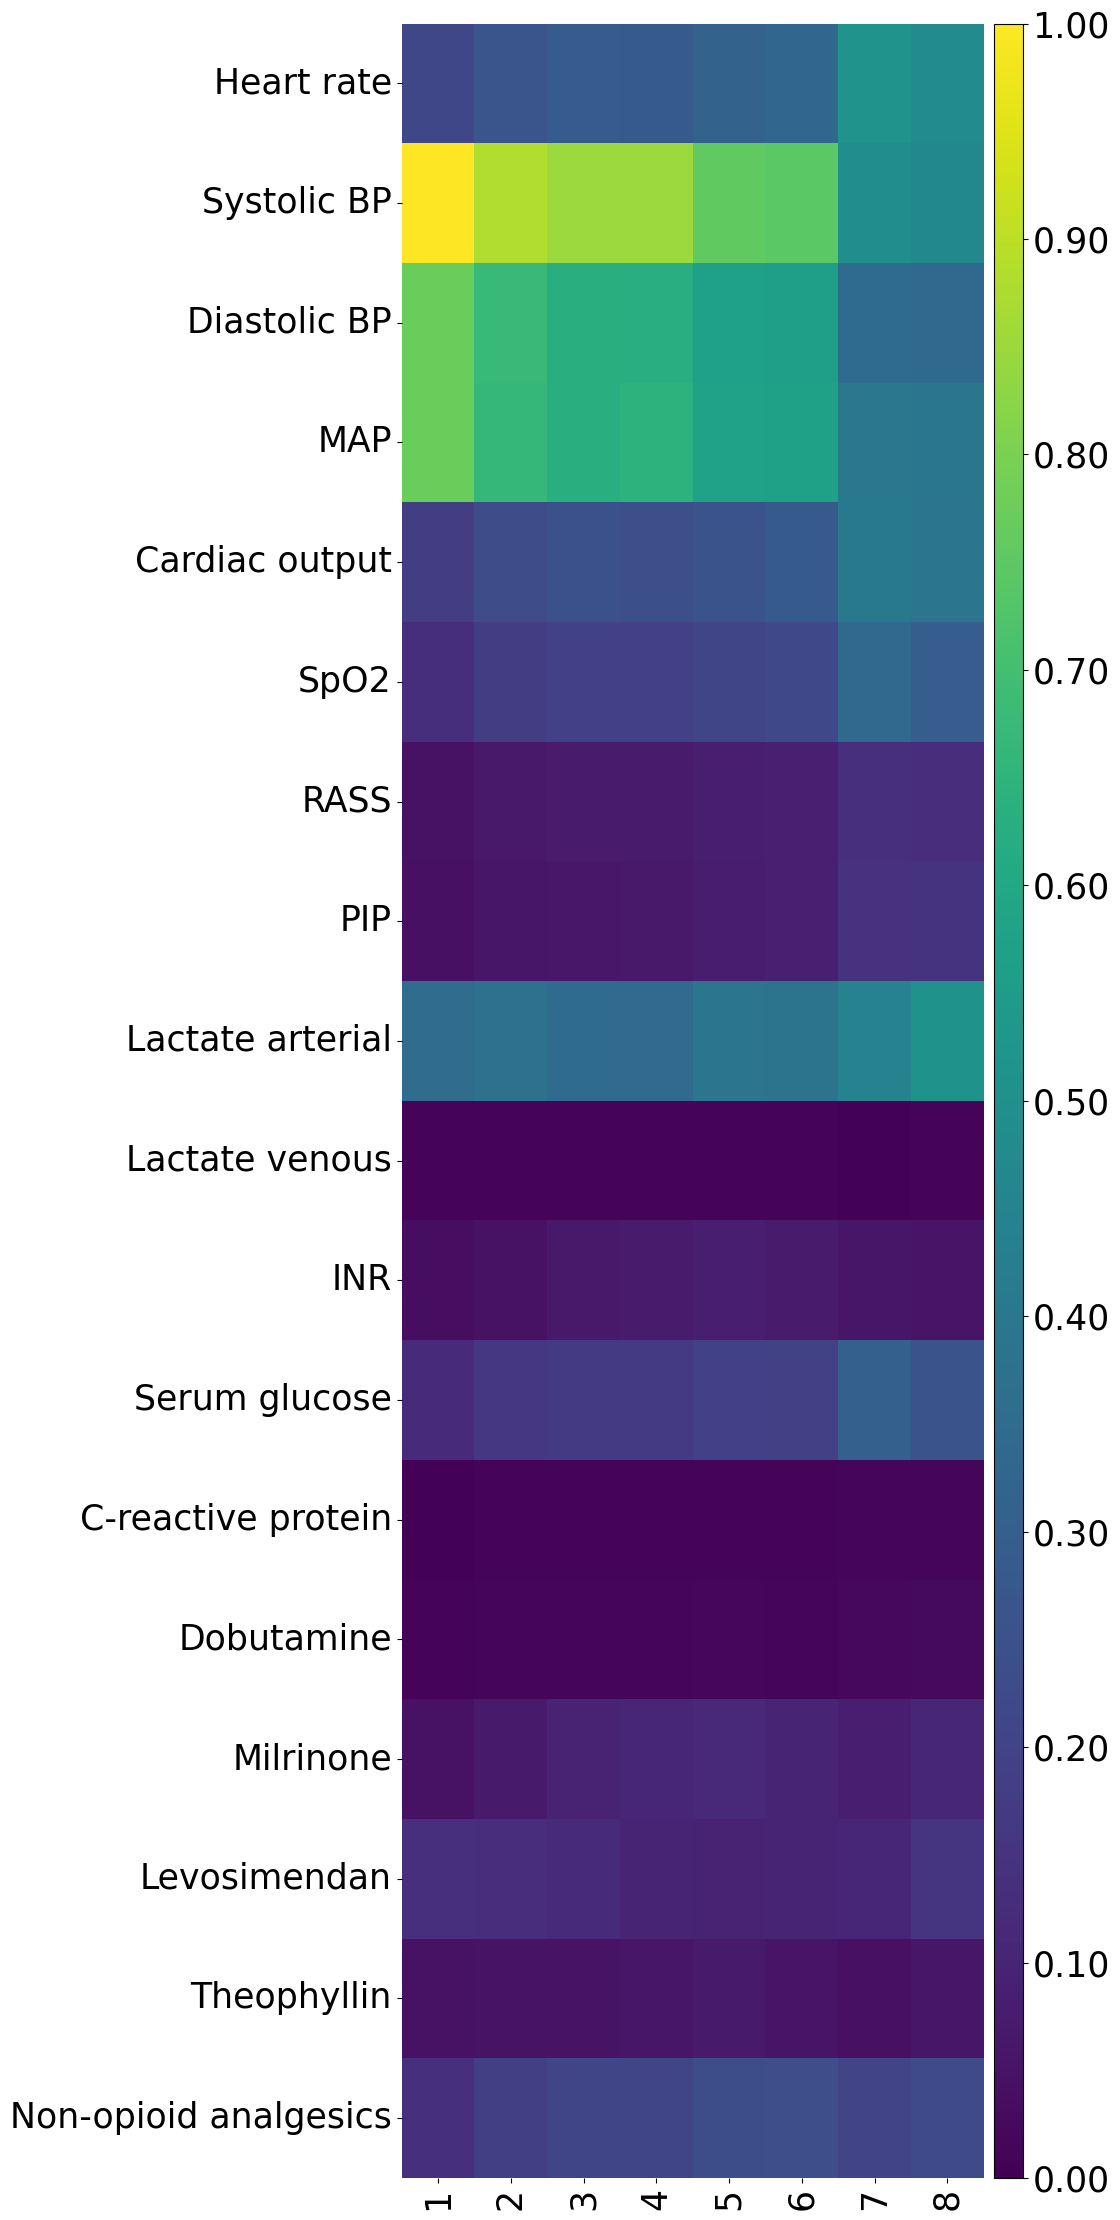

In [7]:
dfsplits_pop = []


for i in [1, 2, 3]:
    
    X_test = np.load(f"../../../DATA/CIRCULATORY/s{i}/X_test_tensor_{norm}.npy")    
    weights = hadamard_scores_data[str(i)][0]

    matrix = np.zeros(weights.shape)

    # Replace weights with NaN where X_test equals 666
    for j in range(weights.shape[2]):
        matrix[:, :, j] = np.where(X_test[:, :, j] == 666, np.nan, weights[:, :, j])

    dfsplits_pop.append(matrix)
    
    # Normalize the weights across each time step (axis=0), avoiding NaN values.
    average_weights_pop = np.nanmean(matrix, axis=0) / np.nanmean(matrix, axis=0).max()
    
    # Reorder the weights according to new_indices
    reordered_average_weights_pop = average_weights_pop.T[new_indices, :]
    
    # Create the heatmap
    plt.figure(figsize=(11,22))
    ax = plt.gca()

    # Explicitly set vmin and vmax to ensure color consistency
    vmin = 0  # Starting point for color scale
    vmax = 1  # Maximum point for color scale
    
    heatmap = sns.heatmap(
        reordered_average_weights_pop,
        cmap='viridis',
        xticklabels=np.arange(reordered_average_weights_pop.shape[1]) + 1,  # Set x-axis tick labels
        yticklabels=final_order,
        ax=ax,
        cbar=False,  # Disable the default color bar
        vmin=vmin,
        vmax=vmax
    )

    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=25)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=25, rotation=90)

    # Create colorbar with consistent ticks from 0 to 1
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cax)
    cbar.ax.tick_params(labelsize=22)

    # Set custom ticks on the colorbar with the first value as 0
    num_ticks = 11
    # Set the number of ticks you want
    tick_locs = np.linspace(vmin, vmax, num_ticks)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in tick_locs])
    cbar.ax.tick_params(labelsize=25)

    # Save and display the plot
    plt.tight_layout(pad=0)
    plt.savefig(f'../Figures/INTRINSIC/GRU_Had_population_s{i}.jpg', bbox_inches='tight', pad_inches=0)
    plt.show()